In [1]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt
from keras import backend as K
from keras.datasets import cifar10
from keras.applications import resnet50
import numpy as np

from utils import display_image
from Generator import Generator
from ProjectedGradientDescent import ProjectedGradientDescent

from art.utils import load_dataset
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod, ProjectedGradientDescent

Using TensorFlow backend.


In [2]:
def preprocess(image, norm=False):
    image = tf.cast(image, tf.float32)
    if norm:
        image = image /255
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

In [3]:
pretrained_model = tf.keras.applications.ResNet50(include_top=True, weights='imagenet')
pretrained_model.trainable = False

In [4]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('cifar10'))

(32, 32, 3)


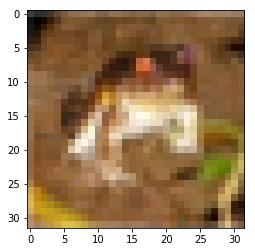

In [5]:
img = x_train[0]
print(img.shape)
plt.imshow(img)
plt.show()

In [6]:
img2 = preprocess(img, norm=False)*255
print(img.shape)
img2[0].shape
print(img2)

(32, 32, 3)
Tensor("mul:0", shape=(1, 224, 224, 3), dtype=float32)


In [7]:
from keras.models import load_model
model = load_model("robust_cifar10_3.h5")
classifier = KerasClassifier(model=model, clip_values=(0., 1.))

In [8]:
preds = pretrained_model.predict(img2, steps=1)
pred2 = classifier.predict(x_train[0:1])
print("PRED2:", pred2)
print('Predicted:', resnet50.decode_predictions(preds, top=3)[0])

PRED2: [[0.00469606 0.01413598 0.02726992 0.3343558  0.00909769 0.5304491
  0.01611978 0.04823598 0.00475025 0.01088934]]
Predicted: [('n04286575', 'spotlight', 0.2554951), ('n03825788', 'nipple', 0.17277), ('n03929660', 'pick', 0.0652386)]


### This is an attack done during training

In [9]:
#Adv training
norm = 2
eps = 0.5
steps = 7
step_size = 0.1
targeted = False

attack_train = ProjectedGradientDescent(classifier=classifier, norm=norm, eps=eps, eps_step=step_size, max_iter=steps, targeted=targeted)

In [10]:
img_train = attack_train.generate(x=x_train[0:1])

pred1 = classifier.predict(x_train[0:1])
print("PRED1:", pred1)
pred2 = classifier.predict(img_train)
print("PRED2:", pred2)

PRED1: [[0.00469606 0.01413598 0.02726992 0.3343558  0.00909769 0.5304491
  0.01611978 0.04823598 0.00475025 0.01088934]]
PRED2: [[2.2168357e-03 2.7476454e-03 3.2414969e-02 3.8175886e-03 6.2972498e-01
  5.6903982e-03 3.0092118e-02 2.9188424e-01 1.9132502e-04 1.2199326e-03]]


(1, 32, 32, 3)


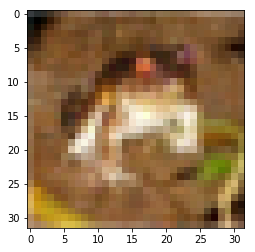

In [11]:
print(img_train.shape)
plt.imshow(img_train[0])
plt.show()

### This is an attack done during generation

In [12]:
#Adv generation
norm = 2
eps = 100
steps = 100
step_size = 0.5
targeted = True

attack_gen = ProjectedGradientDescent(classifier=classifier, norm=norm, eps=eps, eps_step=step_size, max_iter=steps, targeted=targeted)

Maximizing class 0


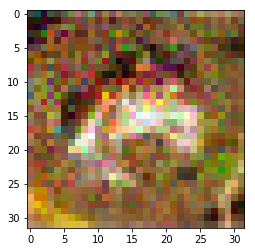

Maximizing class 1


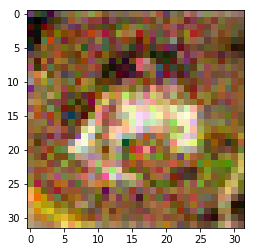

Maximizing class 2


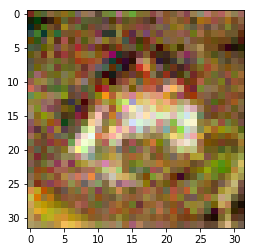

Maximizing class 3


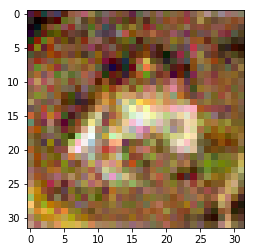

Maximizing class 4


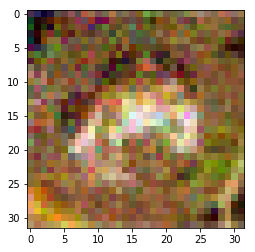

Maximizing class 5


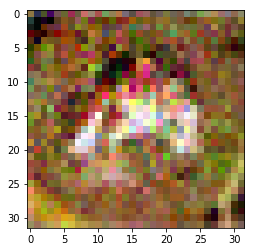

Maximizing class 6


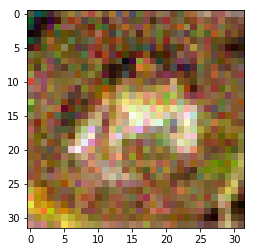

Maximizing class 7


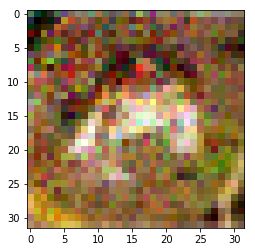

Maximizing class 8


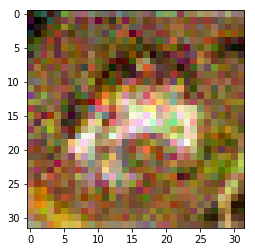

Maximizing class 9


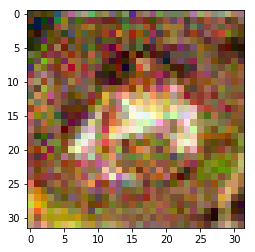

In [13]:
for i in range(10):
    print("Maximizing class", i)
    target_class = i
    prob = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
    prob[0,target_class]=1.
    
    img_gen = attack_gen.generate(x=x_train[0:1], y=prob)
    
    plt.imshow(img_gen[0])
    plt.show()

In [14]:
# pred1 = classifier.predict(x_train[0:1])
# print("PRED1:", pred1)
# pred2 = classifier.predict(img_gen)
# print("PRED2:", pred2)

### Trying to maximize something

Target class: 0


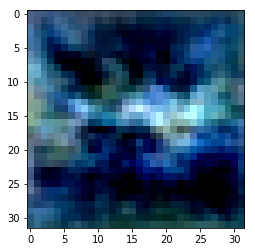

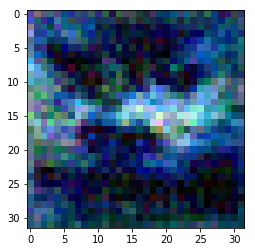

Target class: 1


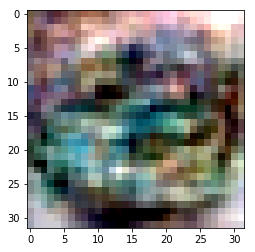

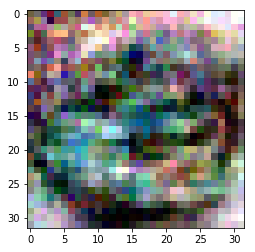

Target class: 2


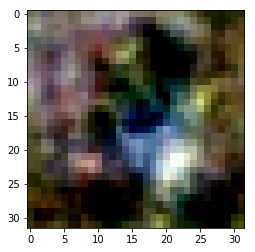

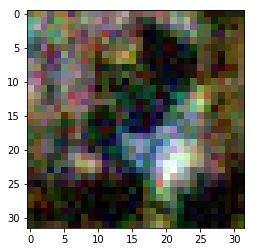

Target class: 3


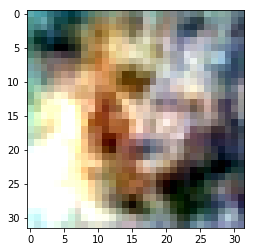

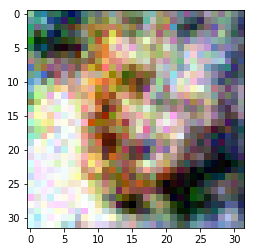

Target class: 4


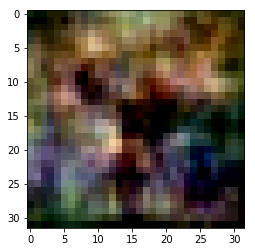

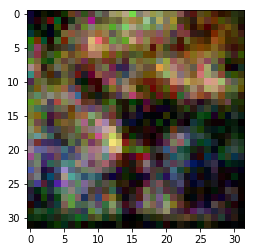

Target class: 5


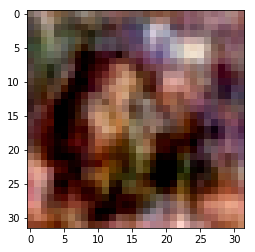

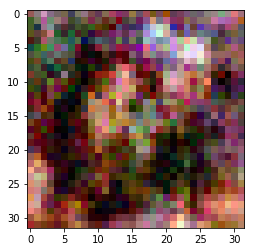

Target class: 6


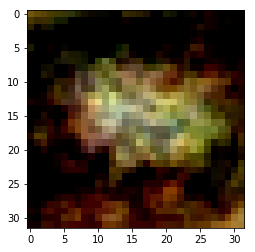

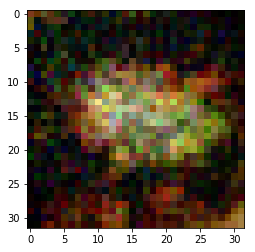

Target class: 7


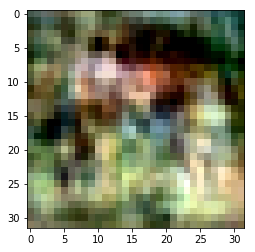

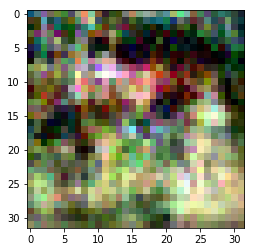

Target class: 8


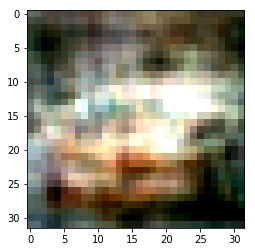

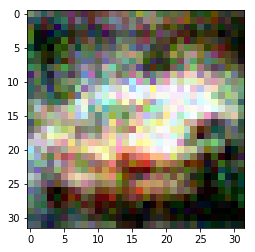

Target class: 9


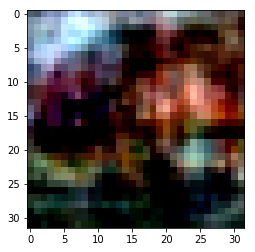

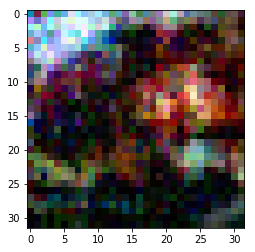

In [15]:
generator = Generator()
generator.calc_class_stats()

for i in range(10):
    print("Target class:", i)
    target = i
    seed = generator.generate_seed(target)
    plt.imshow(seed)
    plt.show()
    
    prob = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
    prob[0,target]=1.
    
    img_gen = attack_gen.generate(x=np.array([seed])/255, y=prob)
    plt.imshow(img_gen[0])
    plt.show()

# OLD

In [16]:
pretrained_model = tf.keras.applications.ResNet50(include_top=True, weights='imagenet')
pretrained_model.trainable = False

image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)

ValueError: 'images' contains no shape.

In [ ]:
preds = pretrained_model.predict(image)
print('Predicted:', resnet50.decode_predictions(preds, top=3)[0])

target_class = 3
n_classes = 1000
prob = tf.one_hot([target_class], n_classes)

pgd = ProjectedGradientDescent(pretrained_model, image, prob)
adv_image = pgd.gen_adv_example(showImage=True)

preds = pretrained_model.predict(adv_image)
print('Predicted:', resnet50.decode_predictions(preds, top=3)[0])

In [ ]:
generator = Generator()
generator.calc_class_stats()

seed = generator.generate_seed(5)
seed_image = preprocess(seed)
display_image(seed, "Seeded image")
display_image(seed_image, "Upsampled seed with tfs bilinear interpolation")

In [ ]:
preds = pretrained_model.predict(seed_image)
print('Predicted:', resnet50.decode_predictions(preds, top=3)[0])

target_class = 5
n_classes = 1000
prob = tf.one_hot([target_class], n_classes)
pgd = ProjectedGradientDescent(pretrained_model, seed_image, prob)
adv_seed = pgd.gen_adv_example(showImage=True)

preds = pretrained_model.predict(adv_seed)
print('Predicted:', resnet50.decode_predictions(preds, top=3)[0])

In [ ]:
generator.visualize_example_seeds()